In [1]:
import arviz as az
import pymc as pm
# import arviz.labels as azl

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import matplotlib as mpl
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, robust_scale
import patsy as pt


ModuleNotFoundError: No module named 'pymc'

## Reestimate model because of pickle problems

In [42]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, kernel_type='M52', bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        covs = []
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                covs.append(pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='exponential':
                covs.append(pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m52':
                covs.append(pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m32':
                covs.append(pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m12':
                covs.append(pm.gp.cov.Matern12(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
                
        # Covariance model
        cov_tot = np.sum(covs)*cov
        
        
        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Model
        if not (prop_Xu is None):
            # Inducing variables
            num_Xu = int(X_a.shape[0]*prop_Xu)
            Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
            gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
        else:
            gp = pm.gp.Marginal(cov_func=cov_tot)
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        
        if not (bayes_kws is None):
            trace = pm.sample(**bayes_kws)
            result = trace
        else:
            start_val = 1
            x0 = dict(zip(['l_'+X_cols[i] for i in range(len(X_cols))], [start_val]*len(X_cols)))
            x0.update({ 'eta': 1, 'sigma_n': 1})

            options={'disp': None, 'maxcor': 10, 
                     'ftol': 2.220446049250313e-12, 'gtol': 1e-12, 
                     'eps': 1e-12, 'maxfun': 15000, 'maxiter': 15000, 
                     'iprint': - 1, 'maxls': 20, 
                     'finite_diff_rel_step': None}
            mp = pm.find_MAP(start = x0, options=options)
            result = mp
    
    return gp, result, model

def bootstrap(n_samples,y, X, seed=42, **kwargs):
    rng = np.random.default_rng(seed)
    all_params = []
    all_preds = []
    i = 0
    while i < n_samples:
        print(' ', i, end=', ')
        ix = np.array(y.index)
        bs_ix = rng.choice(ix, size=len(ix), replace=True)
        new_y, new_X = y.loc[bs_ix, :], X.loc[bs_ix, :]
        try: 
            gp, mp, model = fit_gp(new_y, new_X, **kwargs)
            all_params.append(mp)
            with model:
                y_pred, var = gp.predict(new_X.values, point=mp, diag=True)
                all_preds.append((new_y, y_pred, var))
            i += 1
            
        except: 
            print('error')

    print()

    return all_params, all_preds


def acquisition(x, gp, model, mp, mu_best): 
    x[0] = np.round(x[0], decimals=0)
    x = x.reshape(1, -1)
    y, var = gp.predict(x, pred_noise=True, diag=True, model=model, point=mp)
    
    sigma = np.sqrt(var)
    
    del_mu = (y-mu_best)
    
    z = del_mu/sigma
    
    ei = max(0, norm.cdf(z) + sigma*norm.pdf(z))
    return -1*ei


def exp_imp(y, var, mu_best): 
    sigma = np.sqrt(var)
    
    del_mu = (y-mu_best)
    
    z = del_mu/sigma
    
    ei = np.maximum(0, norm.cdf(z) + sigma*norm.pdf(z))
    return ei
        

## Expected Improvement
First calculate the predictions. 

In [43]:
protein = '1fme'
root_path = f'../{protein}/sensitivity/ts'


experiments = [('dihedrals', None, 'exponential', 'ts' ), 
               ('distances', 'linear', 'exponential', 'ts' ), 
               ('distances', 'logistic', 'exponential', 'ts')]


l_prior = gamma(1, 0.5)
eta_prior = hcauchy(1)
sigma_prior = hcauchy(1)

predictions = []
models = []

for (feat, trans, kernel, dv) in experiments: 

    results_path = Path(root_path).joinpath(f"{feat}_{trans}_{kernel}.pkl")

    results = pickle.load(results_path.open('rb'))
    data_s = results['data_s']
    y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]

    gp, mp, model = fit_gp(y, X, l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior, kernel_type=kernel, bayes_kws=None)

    with model: 
        y_pred, var = gp.predict(X.values, point=mp, pred_noise=True, diag=True)
    
    predictions.append((y_pred, var, y, X))
    models.append((gp, mp, model))

Get incumbent and plot all predictions

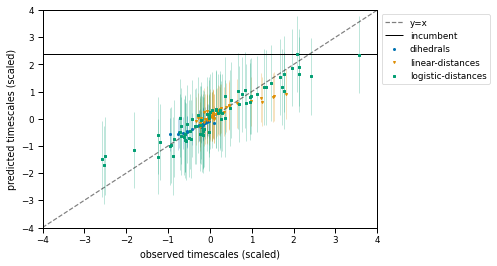

In [44]:
mu_best = np.max(np.concatenate([x[0] for x in predictions]))

with sns.plotting_context('paper'): 
    
    fig, ax = plt.subplots(1)
    shapes = ['o', 'v', 's']
    cols = sns.color_palette('colorblind')
    
    for i, (feat, trans, kernel, dv) in enumerate(experiments): 
        label = feat
        if trans is not None: 
            label = f"{trans}-{label}"
            
        y_pred = predictions[i][0]
        y_err = np.sqrt(predictions[i][1])*2
        y_obs = predictions[i][2].values
        # print(
        ax.errorbar(y_obs, y_pred, yerr=y_err, 
                     lw=0, elinewidth=1, marker=shapes[i], 
                   ms=2, alpha=0.25, color=cols[i])
        
        ax.errorbar(y_obs, y_pred, yerr=y_err, 
                     lw=0, elinewidth=0, marker=shapes[i], label=label,
                   ms=2, alpha=1, color=cols[i])

    lim = 4
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.plot([-lim, lim], [-lim, lim], label='y=x', color='k', 
            ls='dashed', alpha=0.5)

    xlim = ax.get_xlim()

    ax.hlines(mu_best,*xlim, color='k', lw=1,  label='incumbent')
    ax.set_xlim(xlim)
    ax.set_ylabel('predicted timescales (scaled)')
    ax.set_xlabel('observed timescales (scaled)')
    ax.legend(bbox_to_anchor=(1, 1))

    plt.savefig(f'../{protein}/response_surface_predictions_{dv}.pdf', 
                bbox_inches='tight')

Collate data in order to scale consistently

In [45]:
y_pred = np.concatenate([x[0] for x in predictions])
y_var = np.concatenate([x[1] for x in predictions])
data = pd.concat([x[-1] for x in predictions], axis=0)
features = np.concatenate([[experiments[i][0]]*predictions[i][0].shape[0] 
                            for i in range(len(experiments))])
trans = np.concatenate([[experiments[i][1]]*predictions[i][0].shape[0] 
                            for i in range(len(experiments))])
data['feat'] = features
data['trans'] = trans
data['ei'] = exp_imp(y_pred, y_var, np.max(y_pred))

def f(x): 
    try: 
        return ['ca', 'closest-heavy'][int(x)]
    except ValueError: 
        return np.nan
    
    
data['scheme'] = data['scheme[T.closest-heavy]'].apply(f)
data.drop(labels='scheme[T.closest-heavy]', inplace=True, axis=1)
data.tail()

,dim,lag,states,steep,cent,feat,trans,ei,scheme
138,1.214362,-0.390298,0.522370,-1.909767,-1.586097,distances,logistic,0.107051,ca
141,2.589785,0.401612,3.775445,2.957735,3.488031,distances,logistic,0.002149,ca
142,3.621352,-0.390298,1.660946,-0.950315,-1.012192,distances,logistic,0.016795,closest-heavy
144,-0.161061,2.447380,0.901895,2.077958,-1.340460,distances,logistic,0.000015,closest-heavy
145,-1.536484,3.569252,3.179048,1.754021,-0.144593,distances,logistic,0.002244,ca


In [46]:
def scale_df(df, formula, feature_range=None):
    new_df = []
    df = df.copy(deep=True)
    
    dv = formula.split('~')[0].strip()
    x = df[dv].values.reshape(-1, 1)
    print(f'dv is {dv}')
    if dv in ['ts', 'ei']: 
        iqr = np.quantile(np.log(x), 0.75) - np.quantile(np.log(x), 0.25)
        med = np.quantile(np.log(x), 0.5)
        print(f'iqr = {iqr}, median = {med}')
        x = robust_scale(np.log(x), )
        dv_range = (x.min(), x.max())
    elif dv == 'vamp2_eq':
        x = robust_scale(x)
        dv_range = (x.min(), x.max())
    else: 
        raise ValueError('no dep var recognized')
    new_df.append(pd.Series(x.flatten(), name=dv))
    
    print(f'dv range is {dv_range}')    
    if feature_range is None: 
        feature_range = dv_range
    
    df.drop(labels=dv, axis=1, inplace=True)
    
    for col in df.columns: 
        x = df[col].values.reshape(-1, 1)
        if col == 'hp_ix': 
            pass
        elif col in ['dim', 'lag', 'steep', 'cent', 'states']: 
            x = minmax_scale(x, feature_range=feature_range)
        else: 
            pass
        new_df.append(pd.Series(x.flatten(), name=col))
            
    new_df = pd.concat(new_df, axis=1)
    return new_df


def get_dataframes(data_s, feat, trans, formula): 
    X = data_s.query(f"(feat == '{feat}')")
    if trans is not None: 
        X = X.query(f"trans == '{trans}'")
    ydf, Xdf = pt.dmatrices(formula, data=X, return_type='dataframe', NA_action='raise')
    Xdf.drop(labels=['Intercept'], axis=1, inplace=True)
    return ydf, Xdf


data_s = scale_df(data, formula='ei ~ .')


dv is ei
iqr = 8.807052668480674, median = -9.996184378841864
dv range is (-4.801855202786361, 1.106684867374743)


 Save results

In [47]:
for (feat, trans, kernel, dv) in experiments: 

    results_path = Path(root_path).joinpath(f"{feat}_{trans}_{kernel}.pkl")

    results = pickle.load(results_path.open('rb'))
    new_formula = results['formula'].replace(dv, 'ei')
    new_y, new_X = get_dataframes(data_s, feat, trans, new_formula)
    results.pop('trace')
    results['data_s'] = pd.concat([new_y, new_X], axis=1)
    results['formula'] = new_formula

    pickle.dump(results, Path(str(results_path).replace('.pkl', '_with_ei.pkl')).open('wb'))




## Optimisation

Now we focus on the logistic distances 

In [48]:
feat, trans, kernel, _ = experiments[-1]
gp, mp, model = models[-1]
y_pred, y_var, y_obs, X = predictions[-1]
pred_ei = exp_imp(y_pred, y_var, np.max(y_pred))


In [49]:
# sns.pairplot(pd.concat([pred_ei, X], axis=1))

Select grid of points in neighbourhood of top EI points

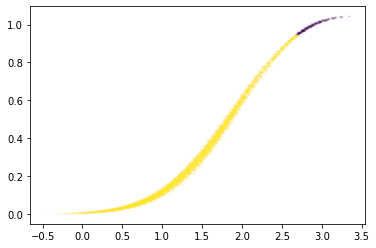

In [50]:
n_points = 5
ei_cutoff = 0.95
xxs = [np.linspace(x, y, n_points) for x, y in 
       zip(X.loc[pred_ei > np.quantile(pred_ei, ei_cutoff), :].min(), 
           X.loc[pred_ei > np.quantile(pred_ei, ei_cutoff), :].max())]
xxs[0] = xxs[0][[0, -1]]
xxs = np.meshgrid(*xxs)
xxs = [xx.reshape(-1, 1) for xx in xxs]
xgrid = np.concatenate(xxs, axis=1)

with model: 
    ygrid, vgrid = gp.predict(xgrid, point=mp, pred_noise=True, diag=True)
    
ei = exp_imp(ygrid, vgrid, mu_best)
plt.scatter(ygrid, ei, alpha=0.1, s=1, c=ei<np.quantile(ei,ei_cutoff))

In [51]:
hp_path = '../../experiments/hpsample.h5'
min_s, max_s = -2.5680505392801685, 3.965207192114922

hps = pd.read_hdf(hp_path)
hps.reset_index(inplace=True)

data = hps.loc[:, ['distances__scheme', 'tica__dim', 'tica__lag', 'cluster__k', 
            'distances__steepness', 'distances__centre']]

data['distances__scheme'] = data['distances__scheme'].apply(lambda x: 1*(x == 'closest-heavy'))
data = data.values

xmin, xmax = data.min(axis=0), data.max(axis=0)
data_grid = (xgrid - min_s)*(xmax - xmin)/(max_s - min_s) + xmin

data_grid[:, 0] = xgrid[:, 0]
data_grid_sorted = data_grid[np.argsort(ei)[::-1], :]

In [52]:
new_hps = []
for i in range(data_grid_sorted.shape[0]): 
    df = hps.iloc[[-1], :].copy(deep=True)
    df['hp_ix'] += i + 1
    df['feature__value'] = feat
    df['distances__transform'] = trans
    df['distances__scheme'] = 'closest-heavy' if np.round(data_grid_sorted[i, 0]) == 1.0 else 'ca'    
    df['tica__dim'] = int(np.round(data_grid_sorted[i, 1]))
    df['tica__lag'] = int(np.round(data_grid_sorted[i, 2]))
    df['cluster__k'] = int(np.round(data_grid_sorted[i, 3]))
    df['distances__steepness'] = data_grid_sorted[i, 4]
    df['distances__centre'] = data_grid_sorted[i, 5]
    new_hps.append(df)
new_hps = pd.concat(new_hps)
new_hps.index = new_hps['hp_ix']
new_hps.drop(labels=['hp_ix'], axis=1, inplace=True)
new_hps.head()

,cluster__max_iter,cluster__stride,tica__dim,tica__lag,tica__kinetic_map,tica__stride,cluster__k,feature__value,dihedrals__which,distances__scheme,distances__transform,distances__steepness,distances__centre
hp_ix,,,,,,,,,,,,,
329,1000,10,20,90,True,1,499,distances,NaN,ca,logistic,5.967568,0.700806
330,1000,10,20,37,True,1,499,distances,NaN,ca,logistic,5.967568,0.700806
331,1000,10,20,90,True,1,489,distances,NaN,ca,logistic,5.967568,0.700806
332,1000,10,20,90,True,1,499,distances,NaN,ca,logistic,5.967568,0.700806
333,1000,10,20,90,True,1,489,distances,NaN,ca,logistic,5.967568,0.700806


In [53]:
for i in range(data_grid_sorted.shape[1]): 
    print(np.sort(np.unique(data_grid_sorted[:, i])))

print(np.sort(new_hps['distances__scheme'].unique()))
print(np.sort(new_hps['tica__dim'].unique()))
print(np.sort(new_hps['tica__lag'].unique()))
print(np.sort(new_hps['cluster__k'].unique()))
print(np.sort(new_hps['distances__steepness'].unique()))
print(np.sort(new_hps['distances__centre'].unique()))

[0. 1.]
[19.   19.25 19.5  19.75 20.  ]
[20.  37.5 55.  72.5 90. ]
[459. 469. 479. 489. 499.]
[ 5.96756834 15.11410137 24.26063439 33.40716741 42.55370044]
[0.22489078 0.38352917 0.54216757 0.70080596 0.85944435]
['ca' 'closest-heavy']
[19 20]
[20 37 55 72 90]
[459 469 479 489 499]
[ 5.96756834 15.11410137 24.26063439 33.40716741 42.55370044]
[0.22489078 0.38352917 0.54216757 0.70080596 0.85944435]


In [54]:
#[0. 1.]
#[16. 17. 18. 19. 20.]
#[20.  37.5 55.  72.5 90. ]
#[459. 469. 479. 489. 499.]
#[ 5.96756834  9.95016436 13.93276039 17.91535641 21.89795243]
#[0.22489078 0.38352917 0.54216757 0.70080596 0.85944435]
#['ca' 'closest-heavy']
#[17 16 18 19 20]
#[38 55 72 20 90]
#[469 479 459 489 499]
#[ 5.96756834  9.95016436 13.93276039 17.91535641 21.89795243]
#[0.70080596 0.85944435 0.54216757 0.38352917 0.22489078]

In [55]:
new_hps.to_hdf(Path(hp_path).resolve().parent.joinpath('new_ts_hpsample.h5'), key='hyperparameters')

/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_28092/2587266326.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['feature__value', 'dihedrals__which', 'distances__scheme',
       'distances__transform'],
      dtype='object')]

  new_hps.to_hdf(Path(hp_path).resolve().parent.joinpath('new_ts_hpsample.h5'), key='hyperparameters')


Attempt to use `scipy.minimize`

In [56]:
xgrid

array([[ 0.        ,  3.62135152, -1.31419299,  3.42302813, -1.77272001,
        -1.58295607],
       [ 0.        ,  3.62135152, -1.31419299,  3.42302813, -1.77272001,
        -0.88806851],
       [ 0.        ,  3.62135152, -1.31419299,  3.42302813, -1.77272001,
        -0.19318096],
       ...,
       [ 1.        ,  3.96520719,  3.30528217,  3.96520719,  3.10331426,
        -0.19318096],
       [ 1.        ,  3.96520719,  3.30528217,  3.96520719,  3.10331426,
         0.5017066 ],
       [ 1.        ,  3.96520719,  3.30528217,  3.96520719,  3.10331426,
         1.19659415]])

In [57]:
xgrid[0:2, :]

array([[ 0.        ,  3.62135152, -1.31419299,  3.42302813, -1.77272001,
        -1.58295607],
       [ 0.        ,  3.62135152, -1.31419299,  3.42302813, -1.77272001,
        -0.88806851]])

In [58]:
x = xgrid[ygrid==np.max(ygrid)][0]
x[0] = np.round(x[0], decimals=0)
x = x.reshape(1, -1)
with model: 
    _, _ = gp.predict(xgrid[0:1, :], pred_noise=True, diag=True, point=mp)
# acquisition(x0, gp, model, mp,  mu_best)
# bounds = [(0, 1), (3, 4), (-1, 4), (3, 4), (-2, 4), (-2, 2)]
# res = minimize(acquisition,x0=x0, method='nelder-mead', options={'disp': True},  
#                args=(gp, model, mp,  mu_best), bounds=bounds)


AssertionError: 

In [ ]:
with model: 
    ygrid, vgrid = gp.predict(xgrid, point=mp, pred_noise=True, diag=True)
    